#### RNN（Recurrent Neural Network）是一类用于处理序列数据的神经网络
#### 多输入单输出(文本分类), 单输入多输出(图像说明),  多输入多输出（输入和输出个数不同）（机器翻译）

#### 循环神经网络的隐藏层的值s不仅仅取决于当前这次的输入x，还取决于上一次隐藏层的值s。权重矩阵 W就是隐藏层上一次的值作为这一次的输入的权重

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [2]:
imdb = keras.datasets.imdb
vocab_size = 10000
index_from = 3

# Keras会预处理这些文字，开始字符是1，每个字符都被+3了
# num_words：词频最高的前num_words个词
# index_from：实际使用的词语的索引起始值
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

In [3]:
print(train_data[0], train_labels[0])
print(train_data.shape, train_labels.shape)
print(len(train_data[0]), len(train_data[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 1
(25000,) (25000,)
218 189


In [4]:
# 词库
word_index = imdb.get_word_index()
print(len(word_index))

88584


In [5]:
# 词库每个值加3
word_index = {key:(value + 3) for key, value in word_index.items()}
list(word_index.items())[:5]

[('fawn', 34704),
 ('tsukino', 52009),
 ('nunnery', 52010),
 ('sonja', 16819),
 ('vani', 63954)]

In [6]:
# 设置词库的前4个值
# 不够的位数，补0
word_index["<PAD>"] = 0
word_index["<START>"] = 1
# 识别不了的，用UNK
word_index["<UNK>"] = 2
word_index["<END>"] = 3

# 词库的key和value交换位置
reverse_word_index = {value:key for key, value in word_index.items()}

# 在词库中，取得对应的单词
def decode(data):
    return " ".join([reverse_word_index.get(index, "<UNK>") for index in data])

In [7]:
# 查看对应的内容
decode(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [8]:
# 涉资最大长度
maxlen=500

# 补齐长度
train_data = keras.preprocessing.sequence.pad_sequences(
    train_data,
    maxlen=maxlen,
    dtype='int32',
    padding='post',
    truncating='pre',
    value=0.0,)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data,
    maxlen=maxlen,
    dtype='int32',
    padding='post',
    truncating='pre',
    value=0.0,)

### LSTM

In [9]:
embedding_dim = 16

simple_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length =maxlen),
    
    # units: 正整数，输出空间的维度。
    # return_sequences: 布尔值。是返回输出序列中的最后一个输出，还是全部序列。
    keras.layers.LSTM(units=64, return_sequences=True),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  
])

simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 500, 64)           20736     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 184,961
Trainable params: 184,961
Non-trainable params: 0
_________________________________________________________________


In [10]:
simple_rnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]
history = simple_rnn_model.fit(train_data, train_labels, epochs=20, validation_split=0.3, batch_size=128)
# 25000 * 0.7 / 128 = 137

Epoch 1/20
137/137 [==============================] - 70s 511ms/step - loss: 0.6487 - accuracy: 0.6195 - val_loss: 0.6068 - val_accuracy: 0.7023
Epoch 2/20
137/137 [==============================] - 83s 604ms/step - loss: 0.6230 - accuracy: 0.6766 - val_loss: 0.6200 - val_accuracy: 0.6811
Epoch 3/20
137/137 [==============================] - 87s 632ms/step - loss: 0.6779 - accuracy: 0.5417 - val_loss: 0.6880 - val_accuracy: 0.5269
Epoch 4/20
137/137 [==============================] - 84s 611ms/step - loss: 0.6325 - accuracy: 0.6293 - val_loss: 0.5088 - val_accuracy: 0.7971
Epoch 5/20
137/137 [==============================] - 84s 616ms/step - loss: 0.5935 - accuracy: 0.7179 - val_loss: 0.6423 - val_accuracy: 0.7613
Epoch 6/20
137/137 [==============================] - 83s 608ms/step - loss: 0.5457 - accuracy: 0.7506 - val_loss: 0.6748 - val_accuracy: 0.5015
Epoch 7/20
137/137 [==============================] - 84s 613ms/step - loss: 0.6523 - accuracy: 0.7890 - val_loss: 0.6357 - val_ac

In [12]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()

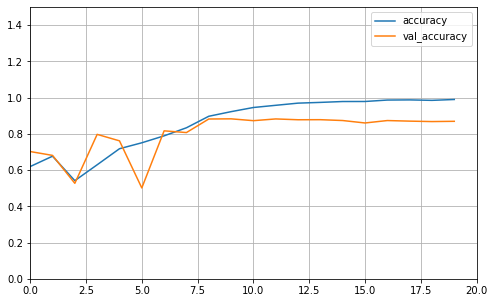

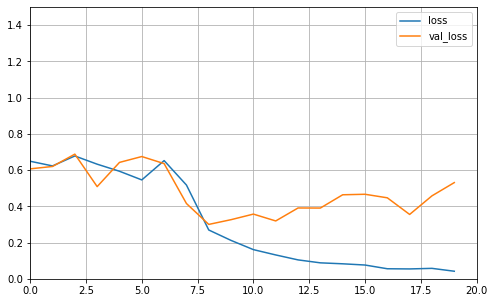

In [13]:
plot_learning_curves(history, 'accuracy', 20, 0, 1.5)
plot_learning_curves(history, 'loss', 20, 0, 1.5)

In [14]:
simple_rnn_model.evaluate(test_data, test_labels, batch_size=128)

196/196 [==============================] - 45s 231ms/step - loss: 0.6183 - accuracy: 0.8434


[0.618274450302124, 0.8434000015258789]

### Bidirection LSTM(双向RNN)

In [15]:
bidirection_simple_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length =maxlen),
    
    # units: 正整数，输出空间的维度。
    # return_sequences: 布尔值。是返回输出序列中的最后一个输出，还是全部序列。
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=64, return_sequences=True)),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  
])

simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 500, 64)           20736     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 184,961
Trainable params: 184,961
Non-trainable params: 0
_________________________________________________________________


In [16]:
bidirection_simple_rnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
bidirection_history = bidirection_simple_rnn_model.fit(
    train_data, train_labels, epochs=10, validation_split=0.3, batch_size=128)

Epoch 1/20
137/137 [==============================] - 409s 3s/step - loss: 0.6355 - accuracy: 0.6462 - val_loss: 0.6820 - val_accuracy: 0.5931
Epoch 2/20
137/137 [==============================] - 457s 3s/step - loss: 0.5898 - accuracy: 0.6934 - val_loss: 0.5828 - val_accuracy: 0.7004
Epoch 3/20
137/137 [==============================] - 471s 3s/step - loss: 0.4963 - accuracy: 0.7833 - val_loss: 0.4895 - val_accuracy: 0.7820
Epoch 4/20
137/137 [==============================] - 715s 5s/step - loss: 0.4392 - accuracy: 0.8098 - val_loss: 0.5516 - val_accuracy: 0.6885
Epoch 5/20
137/137 [==============================] - 832s 6s/step - loss: 0.4044 - accuracy: 0.8403 - val_loss: 0.4248 - val_accuracy: 0.8336
Epoch 6/20
137/137 [==============================] - 497s 4s/step - loss: 0.5191 - accuracy: 0.7226 - val_loss: 0.6881 - val_accuracy: 0.5104
Epoch 7/20
137/137 [==============================] - 311s 2s/step - loss: 0.6744 - accuracy: 0.5490 - val_loss: 0.6756 - val_accuracy: 0.5128

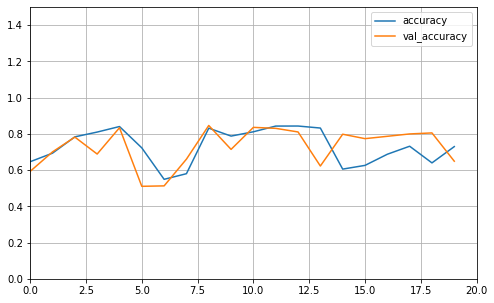

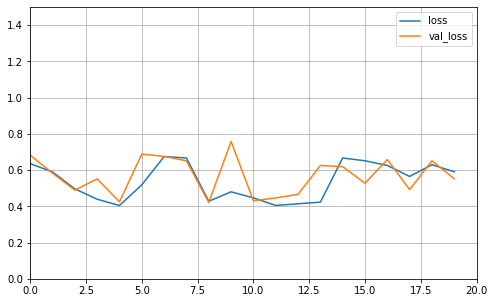

In [18]:
plot_learning_curves(bidirection_history, 'accuracy', 20, 0, 1.5)
plot_learning_curves(bidirection_history, 'loss', 20, 0, 1.5)

In [19]:
bidirection_simple_rnn_model.evaluate(test_data, test_labels, batch_size=128)

196/196 [==============================] - 44s 225ms/step - loss: 0.5655 - accuracy: 0.6417


[0.5655348300933838, 0.6417199969291687]